# DSCI 572 Dropout demo

In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline

### Demo: RBF features fitting with dropout

Dropout is not just for neural networks!

#### generate some random data in 1-d

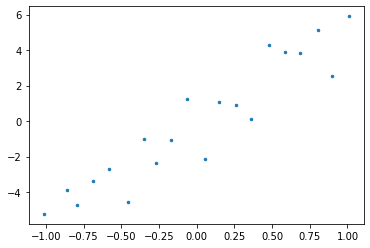

In [2]:
n = 20
X = np.linspace(-1,1,n)+npr.randn(n)*0.01
X=X[:,None]
y = npr.randn(n,1) + X*5

plt.plot(X,y,'.',markersize=5);

#### try fitting with RBF features

[11.11753207]
Loss = 0.000000


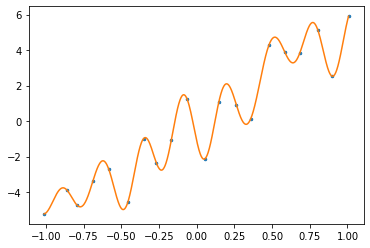

In [8]:
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

class RBF_features():
    def __init__(self, sigma=1):
        self.sigma=sigma

    def fit(self,Xtrain):
        self.Xtrain = Xtrain
    
    def transform(self, Xtest):
        return np.exp(-0.5*euclidean_dist_squared(Xtest,self.Xtrain)/self.sigma**2)

    
rbf = RBF_features(sigma=0.1)
rbf.fit(X)

grid = np.linspace(min(X),max(X),1000)
grid_Z = rbf.transform(grid)

Z = rbf.transform(X)
w = npla.solve(Z.T@Z,Z.T@y)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)

The above model looks like it overfits. We now try to combat this with

#### add L2-regularization

(20, 20)
[2.32533489]
Loss = 34.493230


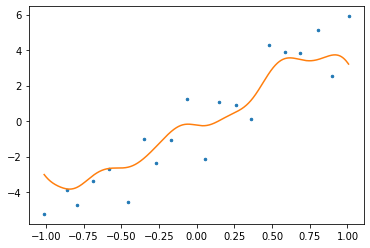

In [9]:
# add regularization
print(Z.shape)
d = Z.shape[1]

reg_strength = 1
w = npla.solve(Z.T @ Z + reg_strength*np.eye(d), Z.T @ y)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)

(above) regularization seems to work

#### back to the unregularized problem, but this time with gradient descent instead of normal eqn's

[10.98254735]
Loss = 0.005524
[[5.38167536e-08]]


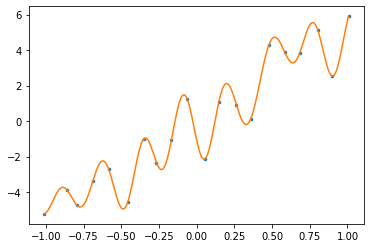

In [10]:
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000

reg_strength = 0

ZTZ = Z.T@Z + reg_strength*np.eye(d)

for t in range(Nsteps):
    
    dLdw = (ZTZ@w-Z.T@y)/n
    w -= alpha*dLdw
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

Above: looks the same as with normal equations, OK good.

#### now we use dropout. At each iteration we randomly select what to drop.

you can drop the activations _or_ the weights

- dropping the weights is more intuitive with respect to the idea of "averaging different architectures"
- the two approaches are basically equivalent. But the implementations are a bit different.
- we'll do both implementations below.

First, dropping the weights

[3.37258932]
Loss = 24.551683
[[0.33631316]]


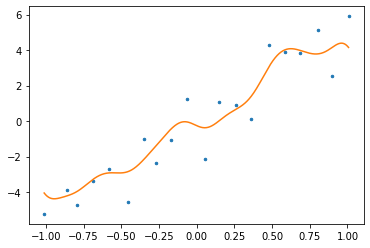

In [11]:
# with dropout 
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000
dropout_prob = 0.25

for t in range(Nsteps):
    

    mask = np.random.rand(d,1) > dropout_prob
    w_drop = w * mask     # dropping the weights

    dLdw = (Z.T@Z@w_drop-Z.T@y)/n
    w -= alpha*dLdw*mask
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

w = w * (1-dropout_prob) # scale for prediction - this is important

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
# print(w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

Above: dropout seems to do what we expect! That is great. You can play around with the dropout probability to see how it behaves.

** note the line of code where we scale $w$ at the end **

- we need to "make testing like training" but we want to use all the weights during testing
- so we just scale things down proportionally since we're using more weights than usual

[3.33131684]
Loss = 24.757861
[[0.07435571]]


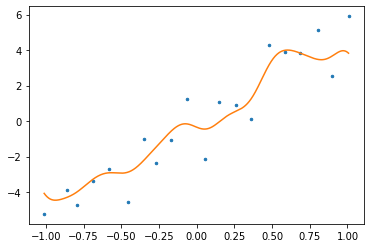

In [13]:
# dropout demo but dropping the activations instead of the weights

# with dropout 
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000
dropout_prob = 0.25

for t in range(Nsteps):
    
    # can dropout the Z's or the w's probably
    mask = np.random.rand(*Z.shape) > dropout_prob
    Z_drop = Z * mask

    dLdw = (Z_drop.T@Z_drop@w-Z_drop.T@y)/n
    w -= alpha*dLdw
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

w = w * (1-dropout_prob) # scale for prediction - this is important

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
# print(w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

(above) The result is almost identical whether you're dropping the weights or the activations. 

- (bonus) There are some other implementation details. Like we can amplify the weights/activations during training instead of dampening them afterwards. This allows flexibility like sampling different dropout probabilities at different iterations.